# ENV

In [1]:
import pandas as pd

Добавляем Environment для крестиков-ноликов из лекции:

In [2]:
import gym
import numpy as np

import tqdm

N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None

        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

 # RL and Advanced DL: Домашнее задание 2
## Часть первая: крестики-нолики при помощи Q-обучения
### Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [3]:
class Q_learning:

    def __init__(self,
                 n_rows: int = 3,
                 n_cols: int = 3,
                 n_win: int = 3,
                 lr: float = 0.01,
                 gamma: float = 1.0):
        self.lr = lr
        self.gamma = gamma
        self.env = TicTacToe()

    def get_possible_actions(self) -> list:
        return [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]

    def greedy_strategy(self, Q: dict, epsilon: float = 0.01):
        possible_actions = self.get_possible_actions()
        if self.env.getState()[0] not in Q.keys():
            Q[self.env.getState()[0]] = np.zeros(len(self.get_possible_actions()))

        if np.random.random() > epsilon:
            return np.argmax(Q[self.env.getState()[0]]), self.get_possible_actions()[np.argmax(Q[self.env.getState()[0]])]
        else:
            ch = np.random.choice(len(possible_actions))
            return ch, possible_actions[ch]

    def game(self, Q: dict, crosses: int = 1):
        self.env.reset()
        opponent_action = lambda: np.random.choice(self.get_possible_actions())

        if self.env.curTurn != crosses:
            self.env.step(self.env.action_from_int(opponent_action()))

        while True:
            state = self.env.getState()[0]
            q_action, action = self.greedy_strategy(Q)
            _, reward, done, _ = self.env.step(self.env.action_from_int(action))
            reward = crosses * reward

            if done:
                Q[state][q_action] += self.lr * (reward  - Q[state][q_action])
                return reward
            else:
                next_state_, reward, done, _ = self.env.step(self.env.action_from_int(opponent_action()))
                reward = crosses * reward
                if done:
                    Q[state][q_action] += self.lr * (reward  - Q[state][q_action])
                    return reward
                else:
                    next_state = next_state_[0]
                    if next_state in Q.keys():
                        Q[state][q_action] += self.lr * (reward + self.gamma * np.max(Q[next_state]) - Q[state][q_action])
                    else:
                        Q[next_state] = np.zeros(len(self.get_possible_actions()))
                        Q[state][q_action] += self.lr * (reward + self.gamma * np.max(Q[next_state]) - Q[state][q_action])


    def games(self, n_games=100000, crosses=1):
        Q = {}
        rewards = [self.game(Q, crosses=crosses) for _ in tqdm.tqdm(range(n_games))]
        return rewards

#### 3 x 3 x 3

In [4]:
games = Q_learning(n_rows=3, n_cols=3, n_win=3)
player1 = games.games(n_games=20_000, crosses=1)
player2 = games.games(n_games=20_000, crosses=-1)

100%|██████████| 20000/20000 [00:05<00:00, 3495.07it/s]


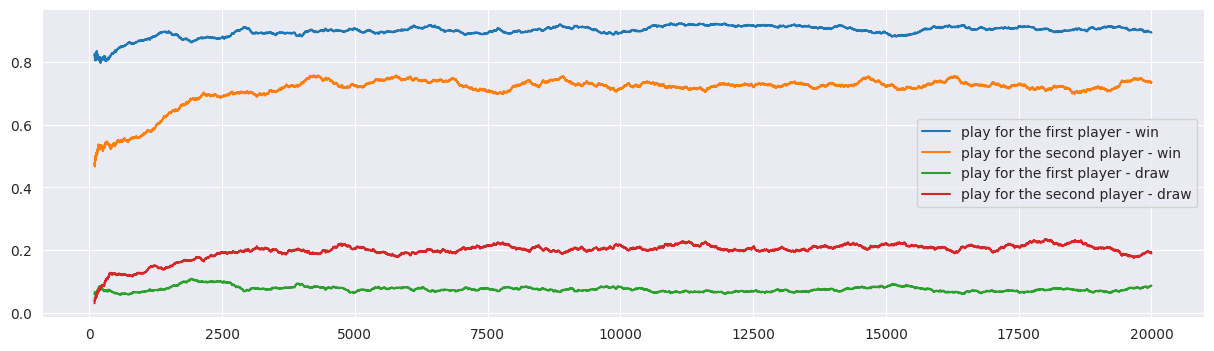

In [5]:
ax = pd.Series(player1).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2) == 0).replace(-1, 1).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

### Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

#### 4 x 4 x 4

In [6]:
games = Q_learning(n_rows=4, n_cols=4, n_win=4)
player1 = games.games(n_games=20_000, crosses=1)
player2 = games.games(n_games=20_000, crosses=-1)

100%|██████████| 20000/20000 [00:05<00:00, 3473.85it/s]


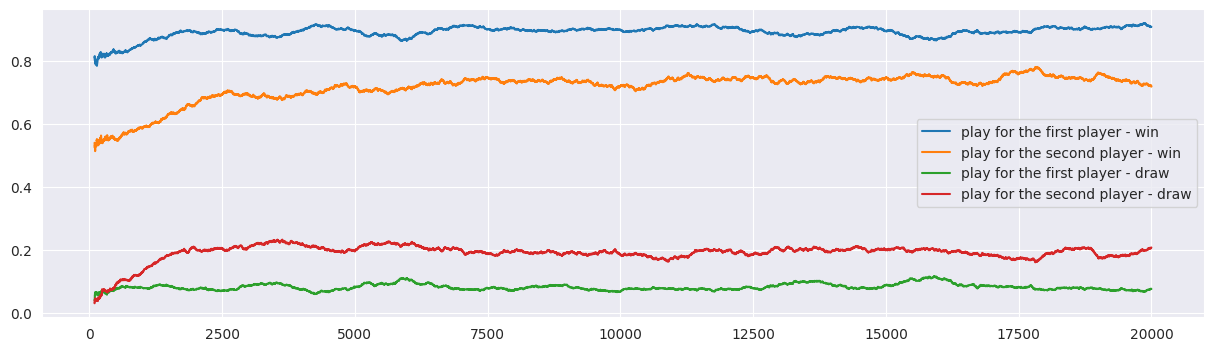

In [7]:
ax = pd.Series(player1).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2) == 0).replace(-1, 1).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

#### 5 x 5 x 5

In [8]:
games = Q_learning(n_rows=5, n_cols=5, n_win=5)
player1 = games.games(n_games=100_000, crosses=1)
player2 = games.games(n_games=100_000, crosses=-1)

100%|██████████| 100000/100000 [00:28<00:00, 3477.34it/s]


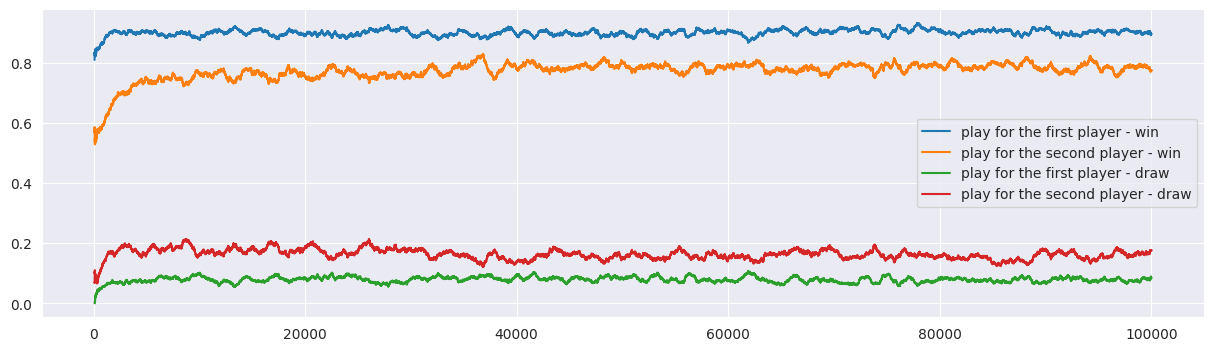

In [9]:
ax = pd.Series(player1).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2) == 0).replace(-1, 1).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

## Часть вторая: добавим нейронных сетей

### Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов

In [4]:
import random
import numpy as np
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, size):
        super(DQN, self).__init__()
        self.conv = nn.Conv2d(1, size ** 2, kernel_size=size)

    def forward(self, x):
        x = self.conv(x)
        return x

class DQN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.dl1 = nn.Linear(9, 36)
        self.dl2 = nn.Linear(36, 36)
        self.output_layer = nn.Linear(36, 9)

    def forward(self, x):
        x = self.dl1(x)
        x = torch.relu(x)

        x = self.dl2(x)
        x = torch.relu(x)

        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class DQN_Learning:
    def __init__(self, n_rows: int = 3, n_cols: int = 3, n_wins: int = 3, n_games: int = 5_000, model = DQN):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(n_rows, n_cols, n_wins)
        self.env = TicTacToe(n_rows, n_cols, n_wins)
        self.n_games = n_games
        self.memory = ReplayMemory(self.n_games)
        self.batch_size = 128
        self.model = model(n_rows).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), 0.01)

    def get_possible_actions(self) -> list:
        return [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]

    def greedy_strategy(self, epsilon: float = 0.01,):
        possible_actions = self.get_possible_actions()
        actions = self.model(torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0).to(self.device)).squeeze(0).cpu().detach().numpy()

        Q_actions = actions[possible_actions]

        if np.random.random() > epsilon:
            return possible_actions[np.argmax(Q_actions)]
        else:
            return np.random.choice(possible_actions)

    def dqn_learn(self, gamma: float = 1):
        batch = self.memory.sample(self.batch_size)

        fstate_batch = [el[0] for el in batch]

        actions = np.array([el[1] for el in batch])

        fnext_state_batch = [el[2][0] for el in batch]
        isTermanal = [el[2][1] for el in batch]
        fnext_actions = [el[2][2] for el in batch]

        reward = np.array([el[3] for el in batch])

        with torch.no_grad():
            predictions = self.model(torch.Tensor(np.array(fnext_state_batch)).unsqueeze(1).to(self.device)).cpu().detach().numpy()
            predicted_target = gamma * np.array([np.max(predictions[i][fnext_actions[i]]) if fnext_actions[i] != [] else 0. for i in range(self.batch_size)])
            predicted_target += reward
            target = torch.Tensor([reward[i] if isTermanal[i] else predicted_target[i] for i in range(self.batch_size)])

        predictions = self.model(torch.Tensor(np.array(fstate_batch)).unsqueeze(1).to(self.device)).cpu().squeeze()

        loss = F.mse_loss(predictions[np.arange(self.batch_size), actions], target)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def game(self, crosses: int = 1):
        self.env.reset()

        if self.env.curTurn != crosses:
            possible_actions = [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]
            opponents_action = np.random.choice(possible_actions)
            self.env.step(self.env.action_from_int(opponents_action))
        loss = 0.

        while True:

            fstate = self.env.board
            action = self.greedy_strategy()

            _, reward, done, _ = self.env.step(self.env.action_from_int(action))
            reward = crosses * reward

            if done:
                self.memory.push(fstate, action, (self.env.board, done, []), reward)
                if len(self.memory) >= self.batch_size:
                    loss += self.dqn_learn()
                return reward, loss

            possible_actions = [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]
            opponents_action = np.random.choice(possible_actions)


            _, reward, done, _ = self.env.step(self.env.action_from_int(opponents_action))
            reward = crosses * reward

            if done:
                self.memory.push(fstate, action, (self.env.board, done, []), reward)
                if len(self.memory) >= self.batch_size:
                    loss += self.dqn_learn()
                return reward, loss
            else:
                fnext_actions = [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]
                self.memory.push(fstate, action, (self.env.board, not done, fnext_actions), reward)
                if len(self.memory) >= self.batch_size:
                    loss += self.dqn_learn()

    def games(self, crosses: int = 1):
        results_losses = [self.game(crosses=crosses) for _ in tqdm.tqdm(range(self.n_games))]
        return [x[0] for x in results_losses], [x[1] for x in results_losses]

In [7]:
dqn = DQN_Learning(model=DQN, n_games=10_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 10000/10000 [00:46<00:00, 216.28it/s]


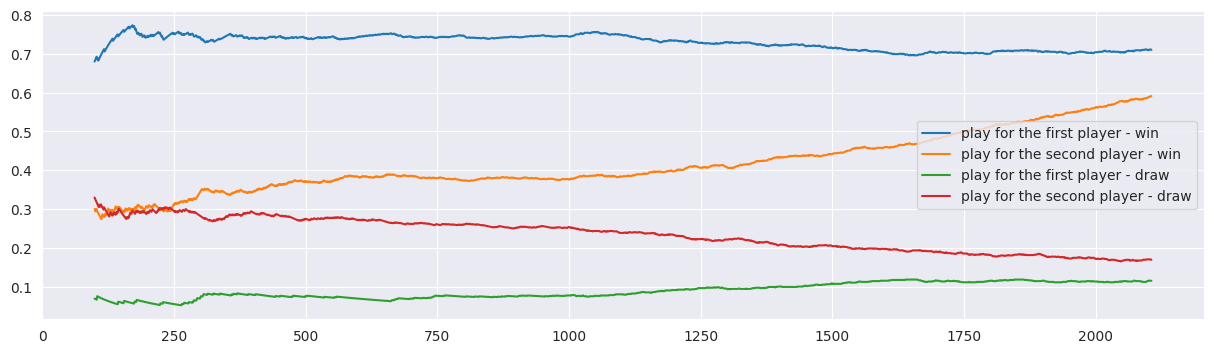

In [8]:
stop_loss = min(pd.Series(player1[1]).rolling(1000, step=1, min_periods=100).mean().idxmax(), pd.Series(player2[1]).rolling(1000, step=1, min_periods=100).mean().idxmax())
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

#### 4 * 4

In [27]:
dqn = DQN_Learning(4, 4, 4, model=DQN, n_games=15_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 15000/15000 [02:45<00:00, 90.66it/s] 


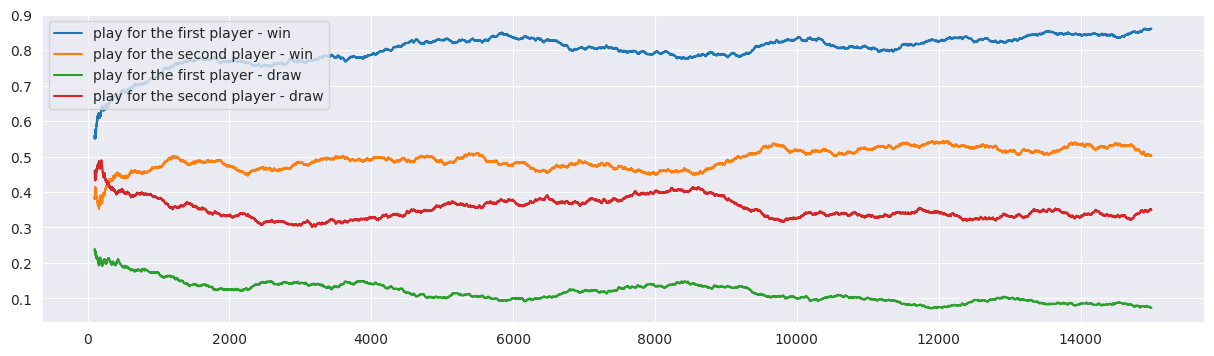

In [28]:
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

#### 5 x 5

In [29]:
dqn = DQN_Learning(5, 5, 5, model=DQN, n_games=5_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 5000/5000 [01:32<00:00, 53.91it/s]


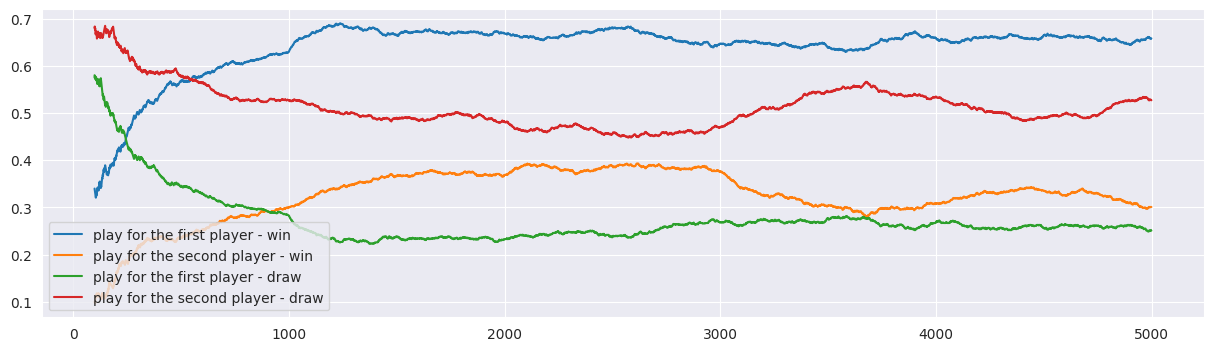

In [30]:
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

### Реализуйте Double DQN и/или Dueling DQN

In [13]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size, n_chanels: int = 32):
        super(DuelingDQN, self).__init__()

        self.field_size = field_size
        self.n_chanels = n_chanels

        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size=self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
        self.l2 = nn.Linear(self.n_chanels, 1)

    def forward(self, x):
        x = torch.tanh(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)

        z = self.l(x)

        y = self.l2(x)
        ma =  torch.mean(z, dim=1, keepdim=True)

        return z + y - ma

In [14]:
dqn = DQN_Learning(model=DuelingDQN, n_games=10_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 10000/10000 [01:22<00:00, 121.77it/s]


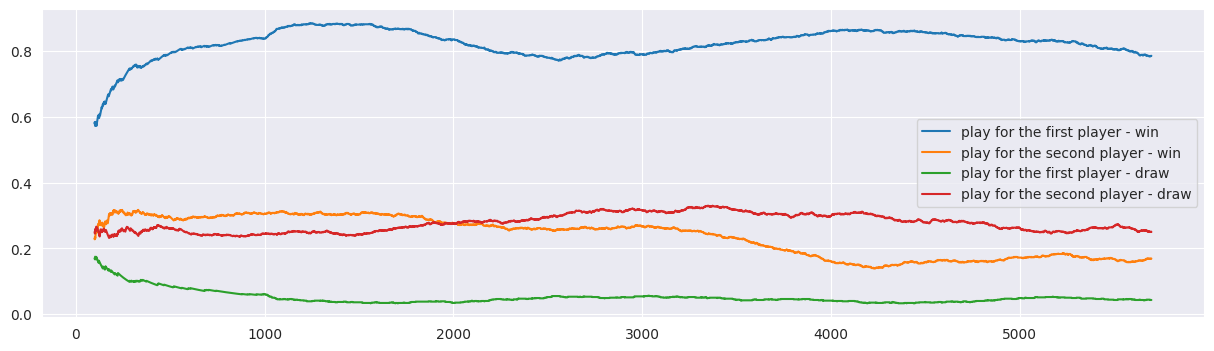

In [15]:
stop_loss = min(pd.Series(player1[1]).rolling(1000, step=1, min_periods=100).mean().idxmax(), pd.Series(player2[1]).rolling(1000, step=1, min_periods=100).mean().idxmax())
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

#### 4 x 4 x 4

In [25]:
dqn = DQN_Learning(4, 4, 4, model=DuelingDQN, n_games=5_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 5000/5000 [01:10<00:00, 70.53it/s]


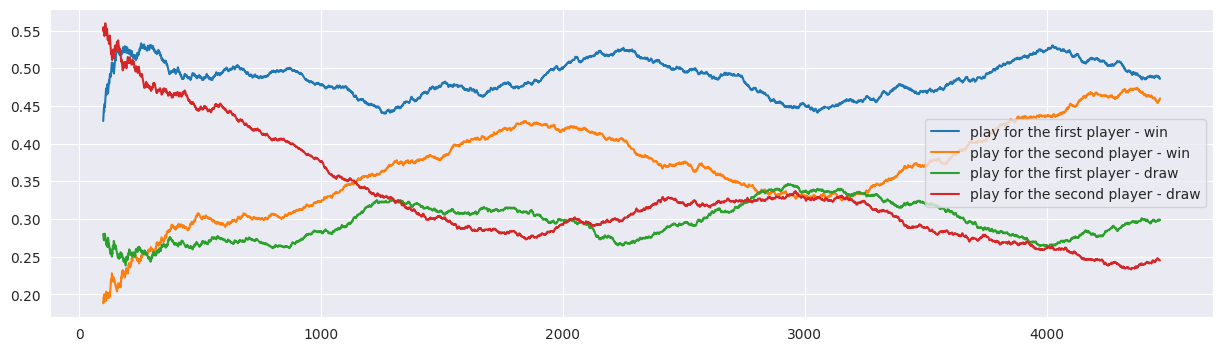

In [26]:
stop_loss = min(pd.Series(player1[1]).rolling(1000, step=1, min_periods=100).mean().idxmax(), pd.Series(player2[1]).rolling(1000, step=1, min_periods=100).mean().idxmax())
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().iloc[:stop_loss].plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

#### 5 x 5 x 5

In [18]:
dqn = DQN_Learning(5, 5, 5, model=DuelingDQN, n_games=10_000)
player1 = dqn.games(crosses=1)
player2 = dqn.games(crosses=-1)

100%|██████████| 10000/10000 [04:15<00:00, 39.10it/s]


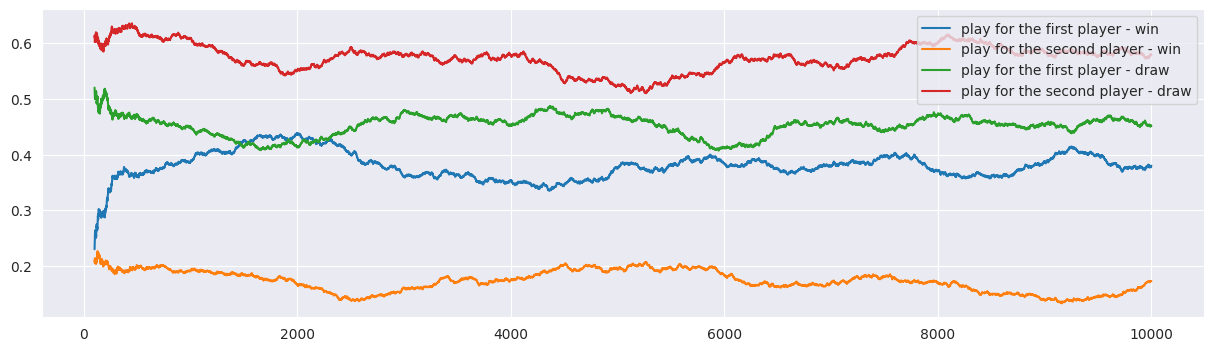

In [22]:
ax = pd.Series(player1[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, label='play for the first player - win',)
pd.Series(player2[0]).replace(-1, 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - win')
(pd.Series(player1[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the first player - draw')
(pd.Series(player2[0]) == 0).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True, ax=ax, label='play for the second player - draw')
ax.legend()

## Часть третья: расширим и углубим поиск

### Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией

In [32]:
# Доигрывает партию, совершая в начале действие action
class RandomRollout:

    def __init__(self,
                 n_rows: int = 3,
                 n_cols: int = 3,
                 n_win: int = 3,
                 lr: float = 0.01,
                 gamma: float = 1.0):
        self.lr = lr
        self.gamma = gamma
        self.env = TicTacToe()

    def get_possible_actions(self) -> list:
        return [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]

    def random_strategy(self):
        possible_actions = self.get_possible_actions()
        ch = np.random.choice(len(possible_actions))
        return possible_actions[ch]

    def game(self, crosses: int = 1):
        self.env.reset()
        opponent_action = lambda: np.random.choice(self.get_possible_actions())

        if self.env.curTurn != crosses:
            self.env.step(self.env.action_from_int(opponent_action()))

        while True:
            state = self.env.getState()[0]
            _, reward, done, _ = self.env.step(self.env.action_from_int(np.random.choice(self.get_possible_actions())))
            reward = crosses * reward

            if done:
                return reward
            else:
                next_state_, reward, done, _ = self.env.step(self.env.action_from_int(opponent_action()))
                reward = crosses * reward
                if done:
                    return reward

### Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера